<a href="https://colab.research.google.com/github/gongx030/etv2_pioneer/blob/master/H3K27ac_Chip_seq_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Comparing H3K27ac ChIP-seq fold enrichment at early, sustained, and late Etv2 ChIP-seq sites during MEF reprogramming in Brg1 knockout and wild type lines
by Erik Skie

The purpose of this analysis is to determine if the H3K27ac fold enrichment signal is different around +/- 1000 bp of the D1-D7 Etv2 ChIP-seq peaks in the Brg1 KO and the wild type MEF line.

In [ ]:
#@title Load R Magic
%%capture
%load_ext rpy2.ipython
#allows native python notebook to run R

In [ ]:
#@title Start Time
%%R
start_time0 <- Sys.time()

## Set Environment

Package List:
* [SummarizedExperiment](https://bioconductor.org/packages/release/bioc/html/SummarizedExperiment.html): for holding experiment data
* [BiocParallel](https://bioconductor.org/packages/release/bioc/html/BiocParallel.html): for running parallel operations
* [ComplexHeatmap](https://bioconductor.riken.jp/packages/3.8/bioc/html/ComplexHeatmap.html): for arranging multiple heatmaps
* [rtracklayer](https://www.bioconductor.org/packages//2.10/bioc/html/rtracklayer.html): for importing our data
* [EnrichedHeatmap](https://www.bioconductor.org/packages/release/bioc/html/EnrichedHeatmap.html): for generating heatmaps
* [circlize](https://cran.r-project.org/web/packages/circlize/index.html): for coloring heatmaps
* [devtools](https://cran.r-project.org/web/packages/devtools/index.html): for installing the latest version of ComplexHeatmap

In [ ]:
#@title Install packages
%%capture
%%R
system('apt-get -q install libgsl-dev', intern = TRUE)
if (!requireNamespace("BiocManager", quietly = TRUE))
  install.packages("BiocManager")
BiocManager::install(c(
  'SummarizedExperiment', 'BiocParallel', 
  'rtracklayer', 'EnrichedHeatmap'), Ncpus = 2)
install.packages('circlize', 'devtools')
install_github("jokergoo/ComplexHeatmap")


In [ ]:
#@title Import packages
%%capture
%%R
library(BiocParallel)
register(MulticoreParam(2))
library(SummarizedExperiment)
library(devtools)
library(circlize)
library(ComplexHeatmap)
library(EnrichedHeatmap)
library(rtracklayer)

## Download datasets



Dataset Information:
* peaks: our Etv2 ChIP-Seq data peaks at day one and day seven post induction
* Brg1_KO: Brg1 KO MEFS day zero H3K27ac ChIP-Seq data from [Alver et. al. 2017](https://www.nature.com/articles/ncomms14648)
* WT: our wild type MEF H3K27ac Chip-Seq data


In [ ]:
#@title Download data
%%R
peaks <- readRDS(gzcon(url('https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/all_Etv2_peaks.rds')))
peaks <- peaks[peaks$group[, 'MEF_Dox_d1_Etv2'] | peaks$group[, 'MEF_Dox_d7_Etv2']] # taking Etv2 ChIP-seq D1 and D7 datasets
bw_files = c(Brg1_KO = 'https://s3.msi.umn.edu/skiex003/datasets/dataset=AlverBrg1ChIP-seq_version=20201005a/ChIP-seq_Smarca4_H3K27Acl_FE_V2.bw', 
             WT = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_NoDox_d0_H3K27ac_FE.bw') # set filenames Brg1 KO and WT H3K27ac ChIP-seq data
local_bw_files <- gsub('https://s3.msi.umn.edu/', './', bw_files) # rtracklayer::import cannot import from http://
commands <- sprintf('wget -x -c -nH %s', bw_files)
lapply(commands, function(command) system(command)) # download Brg1 KO and WT data
# print file status statements
files_found = 0
if(length(peaks)){ #checks for error in downloading peaks data
    cat("peaks found \n")
    files_found = files_found + 1 
}
else{
    cat("peaks not found")
}
for (files in range(1, length(local_bw_files))){ # checks for error in downloading Brg1 KO and WT data
    if(file.exists(local_bw_files[files])){
        cat(sprintf("%s found \n", names(bw_files))[files])
        files_found = files_found + 1 
    }
    else{
        cat(sprintf("%s not found \n", names(bw_files))[files])    
    }
}
cat(sprintf("files found: (%d out 3)", files_found))

peaks found 
Brg1_KO found 
WT found 
files found: (3 out 3)

## Heatmap of H3K27ac ChIP-seq signals over early, late, and sustained Etv2 ChIP-seq peaks in MEF in Brg1 KO and WT MEFs

In [ ]:
#@title Select the sustained Etv2 ChIP-seq peaks that are present in both D1 and D7 post induction
%%R
expandedpeaks <- peaks[peaks$group[, 'MEF_Dox_d1_Etv2'] | peaks$group[, 'MEF_Dox_d7_Etv2']]
# print peak counts in each condition
cat(sprintf('number of early peaks in: %d\n', sum(expandedpeaks$group[, 'MEF_Dox_d1_Etv2'] & !expandedpeaks$group[, 'MEF_Dox_d7_Etv2'])))
cat(sprintf('number of late peaks in: %d\n', sum(!expandedpeaks$group[, 'MEF_Dox_d1_Etv2'] & expandedpeaks$group[, 'MEF_Dox_d7_Etv2'])))
cat(sprintf('number of sustained peaks in: %d\n', sum(expandedpeaks$group[, 'MEF_Dox_d1_Etv2'] & expandedpeaks$group[, 'MEF_Dox_d7_Etv2'])))

number of early peaks in: 111167
number of late peaks in: 4222
number of sustained peaks in: 12170


In [ ]:
#@title prepare normalized matrix for enriched heatmap
%%R
# setting parameters
extend <- 1000
w <- 50
smooth <- FALSE
target_ratio <- 0.2
mc.cores <- 2
target_width <- width(expandedpeaks)[1]
# generating normalizeToMatrix mat object
mat <- lapply(local_bw_files, function(bw_file){
  cvg <- rtracklayer::import(
    bw_file, 
    which = trim(GenomicRanges::reduce(resize(expandedpeaks, fix = 'center', width = target_width + extend * 2)))
  )  # returned as a GRanges object
  normalizeToMatrix(
    cvg, 
    expandedpeaks, 
    extend = extend, 
    value_column = 'score', 
    mean_mode = 'w0', 
    w = w, 
    smooth = smooth, 
    target_ratio = target_ratio
  )
})
# print peak length and width
cat(sprintf('# peaks : %d\n', length(expandedpeaks)))
cat(sprintf('target width : %d\n', target_width))

# peaks : 127559
target width : 200


In [ ]:
#@title Color scheme of heatmap
%%R
group_cols <- c(
  'Brg1_KO' = 'darkgreen',
  'WT' = 'darkgreen'
)
col_fun <- lapply(1:length(mat), function(i) colorRamp2(quantile(mat[[i]], c(0.005, 0.995)), c('white', group_cols[i])))
names(col_fun) <- names(bw_files)
# print color scheme
for (i in range(1, length(group_cols))){
    cat(sprintf('condition: %s -- color: %s \n', names(group_cols)[i], group_cols[i]))
}

condition: Brg1_KO -- color: darkgreen 
condition: WT -- color: darkgreen 


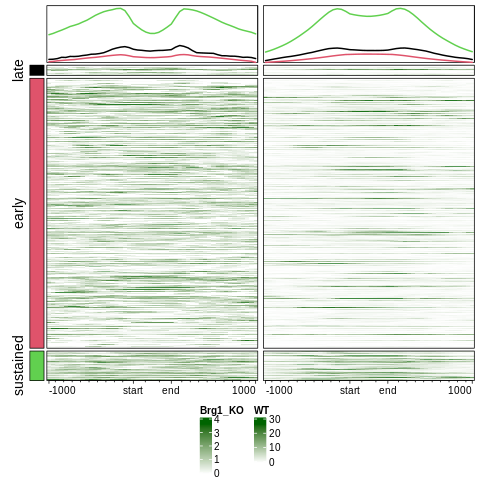

In [ ]:
#@title Generate heatmap
%%R 
i <- 1:length(expandedpeaks)
sp <- factor(sprintf('%s_%s', expandedpeaks$group[, 'MEF_Dox_d1_Etv2'], expandedpeaks$group[, 'MEF_Dox_d7_Etv2'])) #split heatmap into early, late and sustained peaks
ta <- HeatmapAnnotation(enriched = anno_enriched(gp = gpar(lty = 1, lwd = 2, col = 1:nlevels(sp)), 
  axis_param = list(facing = 'inside', at = -1000))) # top heatmap annotation
la <- rowAnnotation(block = anno_block(gp = gpar(fill = 1:nlevels(sp)))) # left heatmap bar annotation
h <- EnrichedHeatmap(mat[['Brg1_KO']][i, ], 
  col = col_fun[['Brg1_KO']], 
  split = sp[i], 
  name = 'Brg1_KO',
  top_annotation = ta, 
  left_annotation = la,
  row_title = c("late", "early", "sustained"),
  pos_line = FALSE,
  ht_opt(message = FALSE)) #ht_opt false silences raster notification
ss <- c('WT') # list of additional heatmaps to build by dataset
for (s in ss[ss %in% names(bw_files)]){
  h <- h + EnrichedHeatmap(mat[[s]][i, ], col = col_fun[[s]], name = s, top_annotation = ta, pos_line = FALSE)
} #build additional heatmaps and add to heatmap list
options(repr.plot.width = 10, repr.plot.height = 10) #fixes display size
draw(h, heatmap_legend_side = 'bottom')

# Session Information

In [ ]:
#@title R Session Information
%%R
sessionInfo()

R version 4.0.2 (2020-06-22)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/openblas/liblapack.so.3

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] grid      parallel  stats4    tools     stats     graphics  grDevices
 [8] utils     datasets  methods   base     

other attached packages:
 [1] rtracklayer_1.48.0          EnrichedHeatmap_1.18.2     
 [3] ComplexHeatmap_2.4.3        circlize_0.4.10            
 [5] devtools_2.3.2              usethis_1.6.3              
 [7] SummarizedExperiment_1.18.2 DelayedA

In [ ]:
#@title Run time
%%R
Sys.time() - start_time0

Time difference of 23.70885 mins
